# Определение возраста покупателей

**Описание проекта**

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:**
- **Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;**
- **Контролировать добросовестность кассиров при продаже алкоголя.**

**Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.**

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
directory='/datasets/faces/final_files/'

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


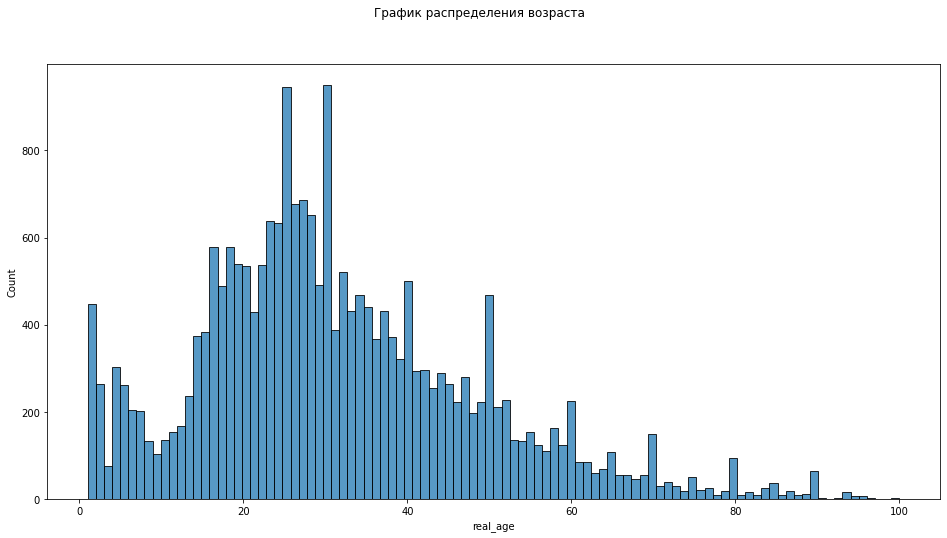

In [5]:
plt.figure(figsize=(16, 8))
sns.histplot(data=labels, x='real_age', weights=3, bins=100)
plt.suptitle('График распределения возраста');

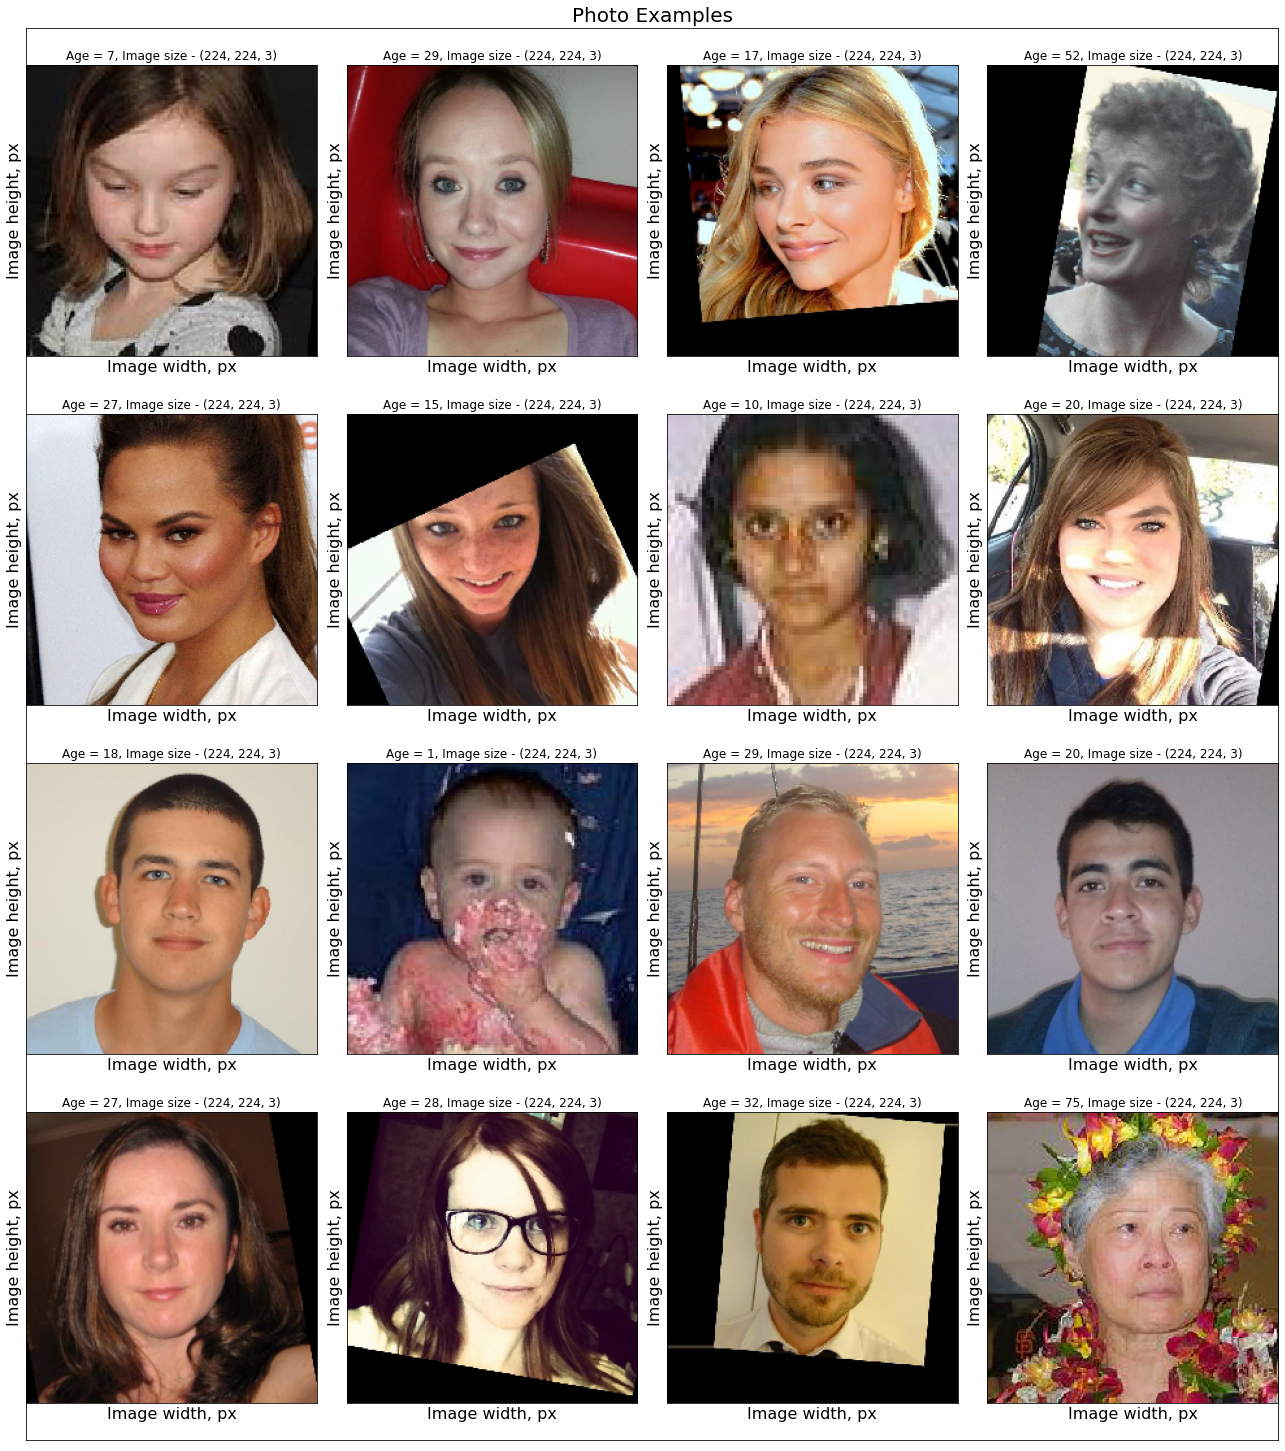

In [21]:
features, target = next(train_gen_flow)

# выводим 16 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 
    plt.title('Age = {}, Image size - {}'.format(target[i], features[i].shape), loc='center')    
    plt.xlabel('Image width, px', fontsize=16)
    plt.ylabel('Image height, px', fontsize=16)

**Представлен датасет с 7591 записью. В датасете содержится информация о возрасте людей на фотографиях всех возрастов. Это хорошо, ведь магазину нужно будет делить покупателей на возрастные группы. Распределение возраста нормальное со смещением влево. Больше всего фотографий людей в возрасте от 16 до 40 лет. Этот возраст модель научится предсказывать лучше всего. Так же имеется много фотографий детей дошкольного возраста, что пригодится для выполнения задачи о добросовестности кассиров. Фотографии также разные: цветные, черно-белые.**

## Обучение модели

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-04-25 17:16:17.423427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-25 17:16:17.795858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 221.0081 - mae: 10.6458 - val_loss: 904.6511 - val_mae: 25.2439
Epoch 2/10
178/178 - 41s - loss: 75.9005 - mae: 6.5698 - val_loss: 727.5989 - val_mae: 21.9218
Epoch 3/10
Epoch 4/10
178/178 - 40s - loss: 48.3495 - mae: 5.2974 - val_loss: 223.6325 - val_mae: 11.1193
178/178 - 40s - loss: 36.1549 - mae: 4.6049 - val_loss: 101.2564 - val_mae: 7.5165
Epoch 5/10
178/178 - 46s - loss: 27.4037 - mae: 3.9928 - val_loss: 76.8879 - val_mae: 6.6063
Epoch 6/10
178/178 - 64s - loss: 22.3888 - mae: 3.6151 - val_loss: 66.3356 - val_mae: 6.1022
Epoch 7/10
178/178 - 48s - loss: 17.9644 - mae: 3.1997 - val_loss: 73.8078 - val_mae: 6.6998
Epoch 8/10
178/178 - 67s - loss: 14.9770 - mae: 2.9300 - val_loss: 61.7466 - val_mae: 5.9514
Epoch 9/10
178/178 - 45s - loss: 11.5868 - mae: 2.5919 - val_loss: 71.7872 - val_mae: 6.3876
Epoch 10/10
178/178 - 51s - loss: 9.9814 - mae: 2.4146 - val_loss: 68.2123 - val_mae: 6.4356
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 68.2123 - mae: 6.4356
Test MAE: 6.4356

```

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    optimizer = Adam(lr=0.0001)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

## Анализ обученной модели

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:**

1) **Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;**

2) **Контролировать добросовестность кассиров при продаже алкоголя.**

**Мы обучили модель определять возраст людей. Данная модель определяет возраст с ошибкой в 6 лет. Очень неплохой результат на мой взгляд (Я могу ошибиться и на 10 и на 15 лет). При помощи этой модели магазин без проблем определит любому покупателю возрастную группу, а сравнительно небольшая погрешность в определении возраста позволит предложить наиболее подходящий товар.**

**С другой стороны, модель не позволит проконтролировать добросовестность кассиров, ведь 15-17 летних подростков она может посчитать 21-23 летними и, наоборот, при продаже алкоголя 20-летнему человеку модель покажет, что кассир продал алкоголь несовершеннолетнему.**